In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt




## The Moe architecture, the expert and the gates and the final architecture

In [3]:

class Expert(nn.Module):
    #individual expert network 
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim))
    
    def forward(self, x):
        return self.net(x)
class GatingNetwork(nn.Module):
    #the gate that gates the network and decides which expert for each
    def __init__(self, input_dim: int, num_experts: int, top_k: int = 2):
        super().__init__()
        self.top_k = top_k
        self.gate = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_experts)
        )
    
    def forward(self, x):
        #the gating score calculation
        logits = self.gate(x)
        
        # top-k gating
        top_k_logits, top_k_indices = torch.topk(logits, self.top_k, dim=-1)
        # softmax that
        top_k_gates = F.softmax(top_k_logits, dim=-1)
        gates = torch.zeros_like(logits).scatter_(1, top_k_indices, top_k_gates)
        return gates, top_k_indices
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, num_experts: int = 4, top_k: int = 2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        #the experts we create
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) 
            for _ in range(num_experts)
        ])
        # the gating network we created earlier
        self.gate = GatingNetwork(input_dim, num_experts, top_k)
        self.load_balance_coef = 0.01
    def forward(self, x):
        batch_size = x.size(0)
        gates, top_k_indices = self.gate(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        gates_expanded = gates.unsqueeze(-1)
        output = torch.sum(expert_outputs * gates_expanded, dim=1)
        load_balance_loss = self._compute_load_balance_loss(gates)
        return output, gates, load_balance_loss
    def _compute_load_balance_loss(self, gates):
        """encourage balanced expert usage across batch"""
        avg_gates = gates.mean(dim=0)
        load_balance_loss = torch.var(avg_gates)
        return load_balance_loss * self.load_balance_coef

## I will work with a synthetic dataset first

In [8]:
class SentimentDataset(Dataset):
    
    def __init__(self, num_samples: int = 2000, input_dim: int = 20):
        self.num_samples = num_samples
        self.input_dim = input_dim
        # 3 clusters (pos,neg,neutr)
        self.data, self.labels = self._generate_data()
    
    def _generate_data(self):
        samples_per_class = self.num_samples // 3
        
        # Class 0: Positive (feature region 1)
        pos_data = np.random.randn(samples_per_class, self.input_dim) * 0.5 + 2.0
        pos_data[:, :5] += 3.0  # Strong signal in first 5 features
        
        # Class 1: Negative (feature region 2)
        neg_data = np.random.randn(samples_per_class, self.input_dim) * 0.5 - 2.0
        neg_data[:, 5:10] -= 3.0  # Strong signal in features 5-10
        
        # Class 2: Neutral (feature region 3)
        neu_data = np.random.randn(samples_per_class, self.input_dim) * 0.3
        neu_data[:, 10:15] += 2.0  # Signal in features 10-15
        
        data = np.vstack([pos_data, neg_data, neu_data])
        labels = np.array([0] * samples_per_class + 
                         [1] * samples_per_class + 
                         [2] * samples_per_class)
        
        # Shuffle
        indices = np.random.permutation(len(data))
        data = data[indices]
        labels = labels[indices]
        
        # Store actual size (might be less than num_samples due to integer division)
        self.num_samples = len(data)  # <--- THIS LINE WAS ADDED
        
        return torch.FloatTensor(data), torch.LongTensor(labels)
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [9]:
INPUT_DIM = 20
HIDDEN_DIM = 64
OUTPUT_DIM = 3  # 3 sentiment classes
NUM_EXPERTS = 4
TOP_K = 2
BATCH_SIZE = 64
NUM_EPOCHS = 30
train_dataset = SentimentDataset(num_samples=2000, input_dim=INPUT_DIM)
test_dataset = SentimentDataset(num_samples=500, input_dim=INPUT_DIM)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = MixtureOfExperts(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_experts=NUM_EXPERTS,
        top_k=TOP_K
    )
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
    
history = {'loss': [], 'acc': [], 'lb_loss': []}
    
for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_lb_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs, gates, lb_loss = model(inputs)
            cls_loss = criterion(outputs, labels)
            loss = cls_loss + lb_loss
            loss.backward()
            optimizer.step()
            total_loss += cls_loss.item()
            total_lb_loss += lb_loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        avg_loss = total_loss / len(train_loader)
        avg_lb_loss = total_lb_loss / len(train_loader)
        accuracy = 100. * correct / total
        history['loss'].append(avg_loss)
        history['lb_loss'].append(avg_lb_loss)
        history['acc'].append(accuracy)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | "
                  f"LB Loss: {avg_lb_loss:.4f} | Acc: {accuracy:.2f}%")


Epoch 5/30 | Loss: 0.0005 | LB Loss: 0.0003 | Acc: 100.00%
Epoch 10/30 | Loss: 0.0001 | LB Loss: 0.0003 | Acc: 100.00%
Epoch 15/30 | Loss: 0.0000 | LB Loss: 0.0002 | Acc: 100.00%
Epoch 20/30 | Loss: 0.0000 | LB Loss: 0.0002 | Acc: 100.00%
Epoch 25/30 | Loss: 0.0000 | LB Loss: 0.0001 | Acc: 100.00%
Epoch 30/30 | Loss: 0.0000 | LB Loss: 0.0001 | Acc: 100.00%


In [10]:

def analyze_expert_specialization(model, test_loader):
    #we wanna see which experts epecialize in which class
    model.eval()
    expert_class_counts = np.zeros((model.num_experts, 3))  # 3 classes
    with torch.no_grad():
        for inputs, labels in test_loader:
            _, gates, _ = model(inputs)
            # Get top expert for each sample
            top_experts = gates.argmax(dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            for expert_idx, label in zip(top_experts, labels_np):
                expert_class_counts[expert_idx, label] += 1
    print("\n=== Expert Specialization Matrix ===")
    print("Rows: Experts | Columns: Classes (0=Pos, 1=Neg, 2=Neu)")
    print(expert_class_counts)
    expert_percentages = expert_class_counts / expert_class_counts.sum(axis=1, keepdims=True) * 100
    print("\n=== Expert Specialization (%) ===")
    print(expert_percentages)
    
    return expert_class_counts


In [11]:
def visualize_results(history, expert_counts):
    """Visualize training and expert specialization"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Training loss
    axes[0].plot(history['loss'], label='Classification Loss')
    axes[0].plot(history['lb_loss'], label='Load Balance Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['acc'], color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training Accuracy')
    axes[1].grid(True, alpha=0.3)
    
    # Expert specialization heatmap
    im = axes[2].imshow(expert_counts, cmap='YlOrRd', aspect='auto')
    axes[2].set_xlabel('Sentiment Class')
    axes[2].set_ylabel('Expert ID')
    axes[2].set_title('Expert Specialization')
    axes[2].set_xticks([0, 1, 2])
    axes[2].set_xticklabels(['Positive', 'Negative', 'Neutral'])
    axes[2].set_yticks(range(expert_counts.shape[0]))
    plt.colorbar(im, ax=axes[2], label='Sample Count')
    
    plt.tight_layout()
    plt.savefig('moe_results.png', dpi=150, bbox_inches='tight')
    print("\n✓ Results saved to 'moe_results.png'")


In [12]:
expert_counts = analyze_expert_specialization(model, test_loader)



=== Expert Specialization Matrix ===
Rows: Experts | Columns: Classes (0=Pos, 1=Neg, 2=Neu)
[[  0. 166.   0.]
 [166.   0.   0.]
 [  0.   0. 166.]
 [  0.   0.   0.]]

=== Expert Specialization (%) ===
[[  0. 100.   0.]
 [100.   0.   0.]
 [  0.   0. 100.]
 [ nan  nan  nan]]


/tmp/ipykernel_39/342727840.py:16: RuntimeWarning: invalid value encountered in divide
  expert_percentages = expert_class_counts / expert_class_counts.sum(axis=1, keepdims=True) * 100



✓ Results saved to 'moe_results.png'


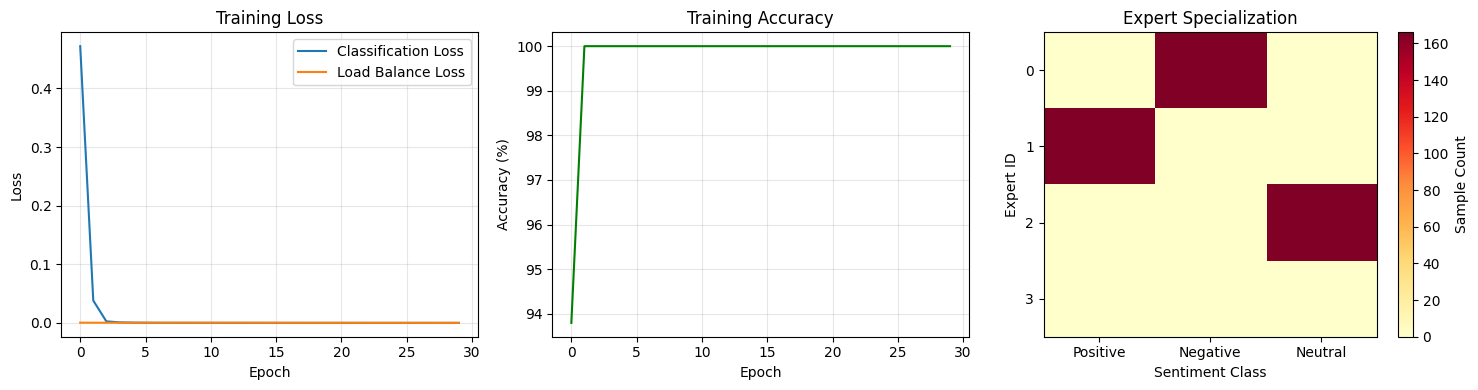

In [13]:
visualize_results(history, expert_counts)